In [93]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from training import *
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
device = device_selection() # mps -> cuda -> cpu

# Initialize environment
env = gym.make('CartPole-v1') 

# hyperparameters
batch_size = 1
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
eps = 0.1
num_workers=1
num_episodes = 10000
total_steps_budget = 500000
max_steps_per_episode = 1000

# neural network structure
input_size = env.observation_space.shape[0] # 4
hidden_size = 64
output_size_actor = env.action_space.n # 2
output_size_critic = 1


# Initialize agent 
agent = Agent(input_size, hidden_size, \
                output_size_actor, output_size_critic, \
                eps, gamma_, lr_actor, lr_critic, num_workers, \
                device=device)

# Initialize batch
batch = []
critic_losses = []
actor_losses = []
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).float().to(device)  # Convert state to a tensor

    episode_reward = 0

    for t in range(max_steps_per_episode):
        action = agent.select_action(state, worker_id=0, policy="eps-greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        agent.num_steps += 1
        
        next_state = torch.from_numpy(next_state).float().to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward

        # Add the experience to the batch
        batch.append((state, action, reward, next_state, done))

        if len(batch) >= batch_size or not done:
            # Train the agent
            worker_losses = agent.train(batch, agent.gamma, agent.lr_actor, agent.lr_critic, agent.device)
            critic_losses.append(worker_losses[0][0])
            actor_losses.append(worker_losses[0][1])
            # Clear the batch
            batch.clear()

        state = next_state
        if done: break
    episode_rewards.append(episode_reward)
    if episode % 100 == 0:
        print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward:.2f}")
        print(f"Actor loss: {actor_losses[-1]:.2f}, Critic loss: {critic_losses[-1]:.2f}")
    
    if (agent.num_steps >= total_steps_budget): 
        print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
        break



Episode 0 finished after 14 steps with reward 14.00
Actor loss: 0.27, Critic loss: 0.17
Episode 100 finished after 46 steps with reward 46.00
Actor loss: -0.96, Critic loss: 1.97
Episode 200 finished after 10 steps with reward 10.00
Actor loss: -15.69, Critic loss: 522.45
Episode 300 finished after 11 steps with reward 11.00
Actor loss: -37.72, Critic loss: 3011.29
Episode 400 finished after 21 steps with reward 21.00
Actor loss: -20.91, Critic loss: 916.67
Episode 500 finished after 41 steps with reward 41.00
Actor loss: -21.20, Critic loss: 966.47
Episode 600 finished after 10 steps with reward 10.00
Actor loss: -22.54, Critic loss: 1095.24
Episode 700 finished after 22 steps with reward 22.00
Actor loss: -33.30, Critic loss: 2427.70
Episode 800 finished after 37 steps with reward 37.00
Actor loss: -53.92, Critic loss: 6082.91
Episode 900 finished after 26 steps with reward 26.00
Actor loss: -47.96, Critic loss: 5102.85
Episode 1000 finished after 29 steps with reward 29.00
Actor los

KeyboardInterrupt: 

## TO IMPLEMENT:

- fix training for multiple workers 
    - wrong computations for target and advantage probably!
    - wrong way to accumulate batches for K>1 right now (right now it's a replay buffer for current agent, should be transitions from K-workers, each worker on different seed of environment in parallel, all have the same networks --> no need to initialize K actor-critic networks?)
    - mini-batch of 256 consequent transitions? wrong
- methods for plotting and training observation (cf 2.3 of project PDF)
- agent class needs method for saving trained models 
- add counting steps to agent class
- output size of policy make dependent on env (not =2 constant)

workers all use the same parameters and get updated with the same gradient at the same time (if not at the same time --> updates with different policies by definition, but A2C is on-policy). Doesn't matter if they (inevitably) end episodes at different time-steps. What matters is they have the same policy when accumulating a batch (same actor-critic params).

batches vanilla are (1x1), in general (num_time_steps x num_workers)

In [106]:
# Initialize batch
critic_losses = []
actor_losses = []
episode_rewards = []
num_episodes_test = 100

for episode in range(num_episodes_test):
    state, _ = env.reset()
    state = torch.from_numpy(state).float().to(device)  # Convert state to a tensor

    episode_reward = 0

    for t in range(max_steps_per_episode):
        action = agent.select_action(state, worker_id=0, policy="greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        agent.num_steps += 1
        
        next_state = torch.from_numpy(next_state).float().to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward
        
        state = next_state
        if done: break
    episode_rewards.append(episode_reward)
    print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward:.2f}")

print(f"Average reward over {num_episodes_test} episodes: {np.mean(episode_rewards):.2f}")


Episode 0 finished after 9 steps with reward 9.00
Episode 1 finished after 10 steps with reward 10.00
Episode 2 finished after 9 steps with reward 9.00
Episode 3 finished after 10 steps with reward 10.00
Episode 4 finished after 9 steps with reward 9.00
Episode 5 finished after 9 steps with reward 9.00
Episode 6 finished after 9 steps with reward 9.00
Episode 7 finished after 9 steps with reward 9.00
Episode 8 finished after 10 steps with reward 10.00
Episode 9 finished after 8 steps with reward 8.00
Episode 10 finished after 10 steps with reward 10.00
Episode 11 finished after 9 steps with reward 9.00
Episode 12 finished after 10 steps with reward 10.00
Episode 13 finished after 10 steps with reward 10.00
Episode 14 finished after 8 steps with reward 8.00
Episode 15 finished after 11 steps with reward 11.00
Episode 16 finished after 9 steps with reward 9.00
Episode 17 finished after 9 steps with reward 9.00
Episode 18 finished after 8 steps with reward 8.00
Episode 19 finished after 8

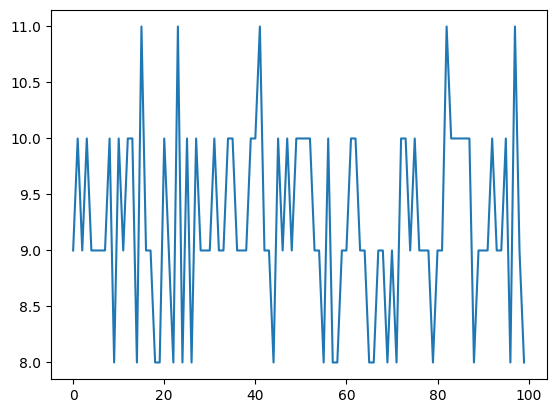

In [107]:
plt.plot(episode_rewards)

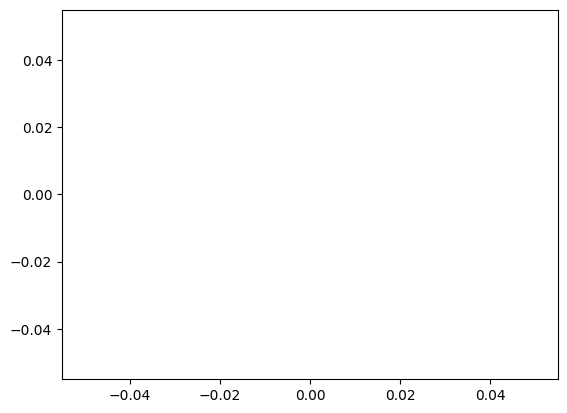

In [108]:
plt.plot(critic_losses)


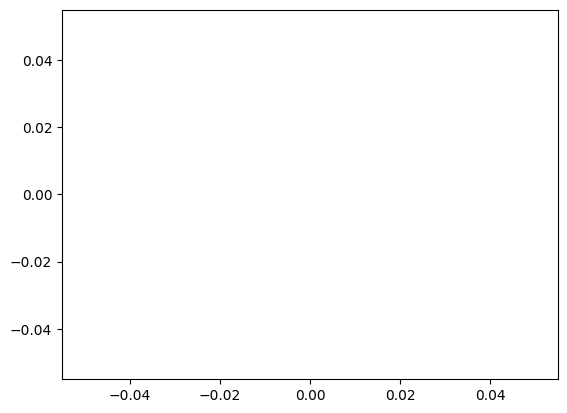

In [109]:
plt.plot(actor_losses)